# CITE-seq analysis with totalVI

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

- Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [2]:
import tempfile

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch

## Imports and data loading

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.).

We run the standard workflow for keeping count and normalized data together.

In [5]:
adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmp322tr27l/pbmc_10k_protein_v3.h5ad                                             
Downloading...: 24938it [00:00, 99895.85it/s]                              
INFO     Downloading file at /tmp/tmp322tr27l/pbmc_5k_protein_v3.h5ad                                              
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 91868.69it/s]


/env/lib/python3.11/site-packages/scvi/data/_built_in_data/_cite_seq.py:47: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset1.obsm["protein_expression"] = pd.DataFrame(
/env/lib/python3.11/site-packages/scvi/data/_built_in_data/_cite_seq.py:52: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset2.obsm["protein_expression"] = pd.DataFrame(
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10849 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch'
    obsm: 'protein_expression'

In [6]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

```{important}
In this tutorial we will show totalVI's compatibility with the [MuData](https://mudata.readthedocs.io/en/latest/api/generated/mudata.MuData.html#mudata.MuData) format, which is a container for multiple AnnData objects. MuData objects can be read from the outputs of CellRanger using `muon.read_10x_h5`.

Furthermore, AnnData alone can also be used by storing the protein count data in `.obsm`, which is how it already is. For the AnnData-only workflow, see the documentation for `setup_anndata` in `scvi.model.TOTALVI`.
```

In [7]:
protein_adata = ad.AnnData(adata.obsm["protein_expression"])
protein_adata.obs_names = adata.obs_names
del adata.obsm["protein_expression"]
mdata = md.MuData({"rna": adata, "protein": protein_adata})
mdata

MuData object with n_obs × n_vars = 10849 × 15806
  2 modalities
    rna:	10849 x 15792
      obs:	'n_genes', 'percent_mito', 'n_counts', 'batch'
      uns:	'log1p'
      layers:	'counts'
    protein:	10849 x 14

In [8]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [9]:
mdata.update()

/env/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


### Setup mudata

Now we run `setup_mudata`, which is the MuData analog to `setup_anndata`. The caveat of this workflow is that we need to provide this function which modality of the `mdata` object contains each piece of data. So for example, the batch information is in `mdata.mod["rna"].obs["batch"]`. Therefore, in the `modalities` argument below we specify that the `batch_key` can be found in the `"rna_subset"` modality of the MuData object.

Notably, we provide `protein_layer=None`. This means scvi-tools will pull information from `.X` from the modality specified in `modalities` (`"protein"` in this case). In the case of RNA, we want to use the counts, which we stored in `mdata.mod["rna"].layers["counts"]`.

In [10]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    batch_key="batch",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



```{note}
Specify the modality of each argument via the `modalities` dictionary, which maps layer/key arguments to MuData modalities.
```

## Prepare and run model

In [11]:
model = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [12]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/env/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to impro

Epoch 365/400:  91%|█████████▏| 365/400 [02:26<00:14,  2.49it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1241.023. Signaling Trainer to stop.


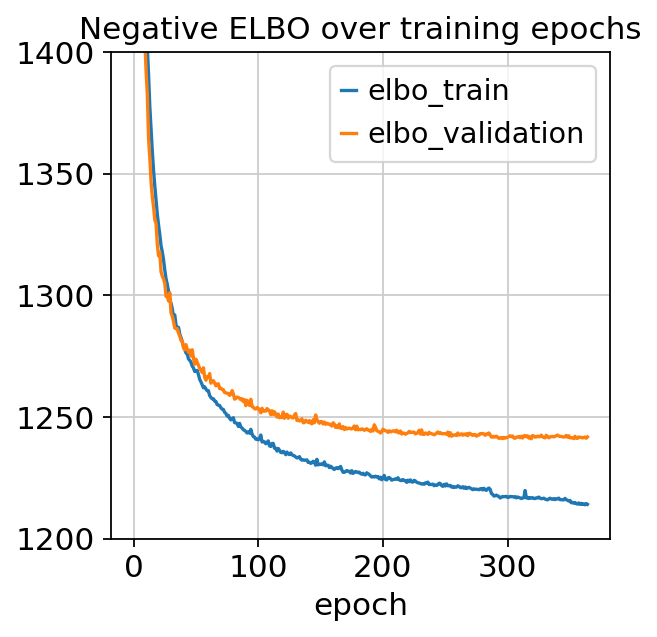

In [13]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 1400))
ax.legend()

## Analyze outputs

We use Scanpy and muon for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow.

In [14]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]

In [15]:
# arbitrarily store latent in rna modality
TOTALVI_LATENT_KEY = "X_totalVI"
rna.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

In [16]:
rna_denoised, protein_denoised = model.get_normalized_expression(
    n_samples=25, return_mean=True, transform_batch=["PBMC10k", "PBMC5k"]
)
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers["protein_foreground_prob"] = (
    100
    * model.get_protein_foreground_probability(
        n_samples=25, return_mean=True, transform_batch=["PBMC10k", "PBMC5k"]
    )
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()

/env/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Now we can compute clusters and visualize the latent space.

In [17]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)

In [18]:
mdata.update()

/env/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


We can now use muon plotting functions which can pull data from either modality of the MuData object.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

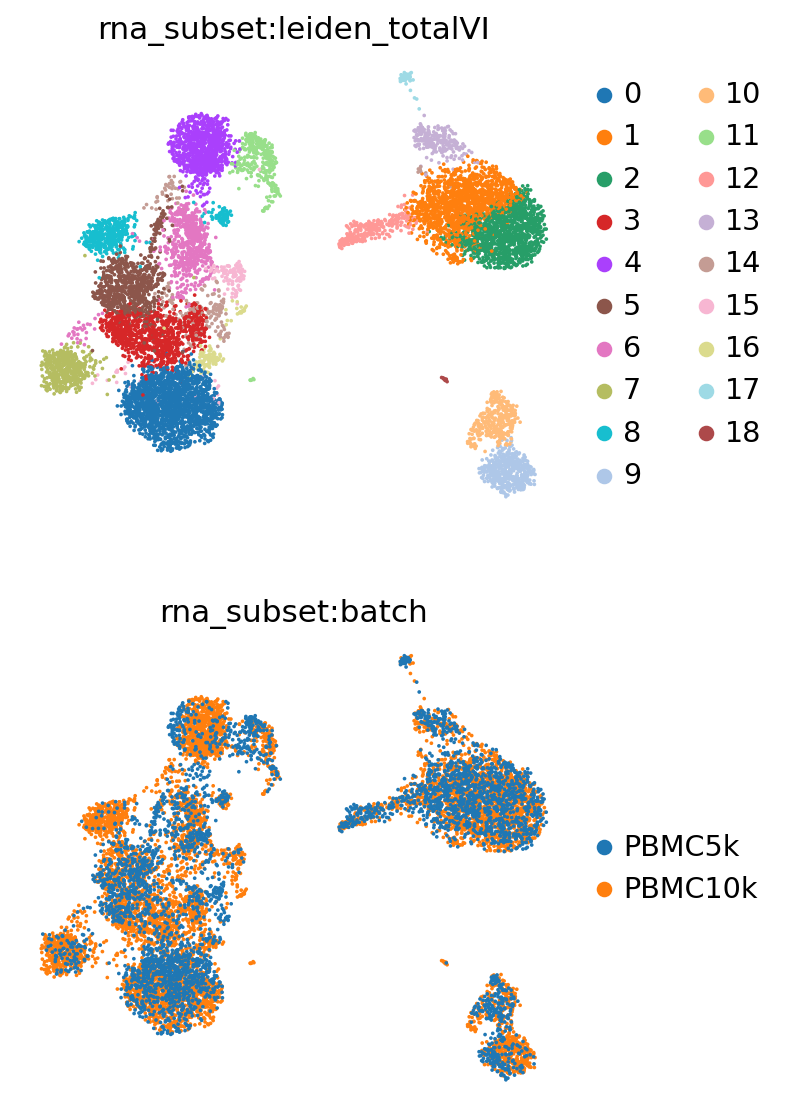

In [19]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color=[f"rna_subset:{TOTALVI_CLUSTERS_KEY}", "rna_subset:batch"],
    frameon=False,
    ncols=1,
)

### Visualize denoised protein values

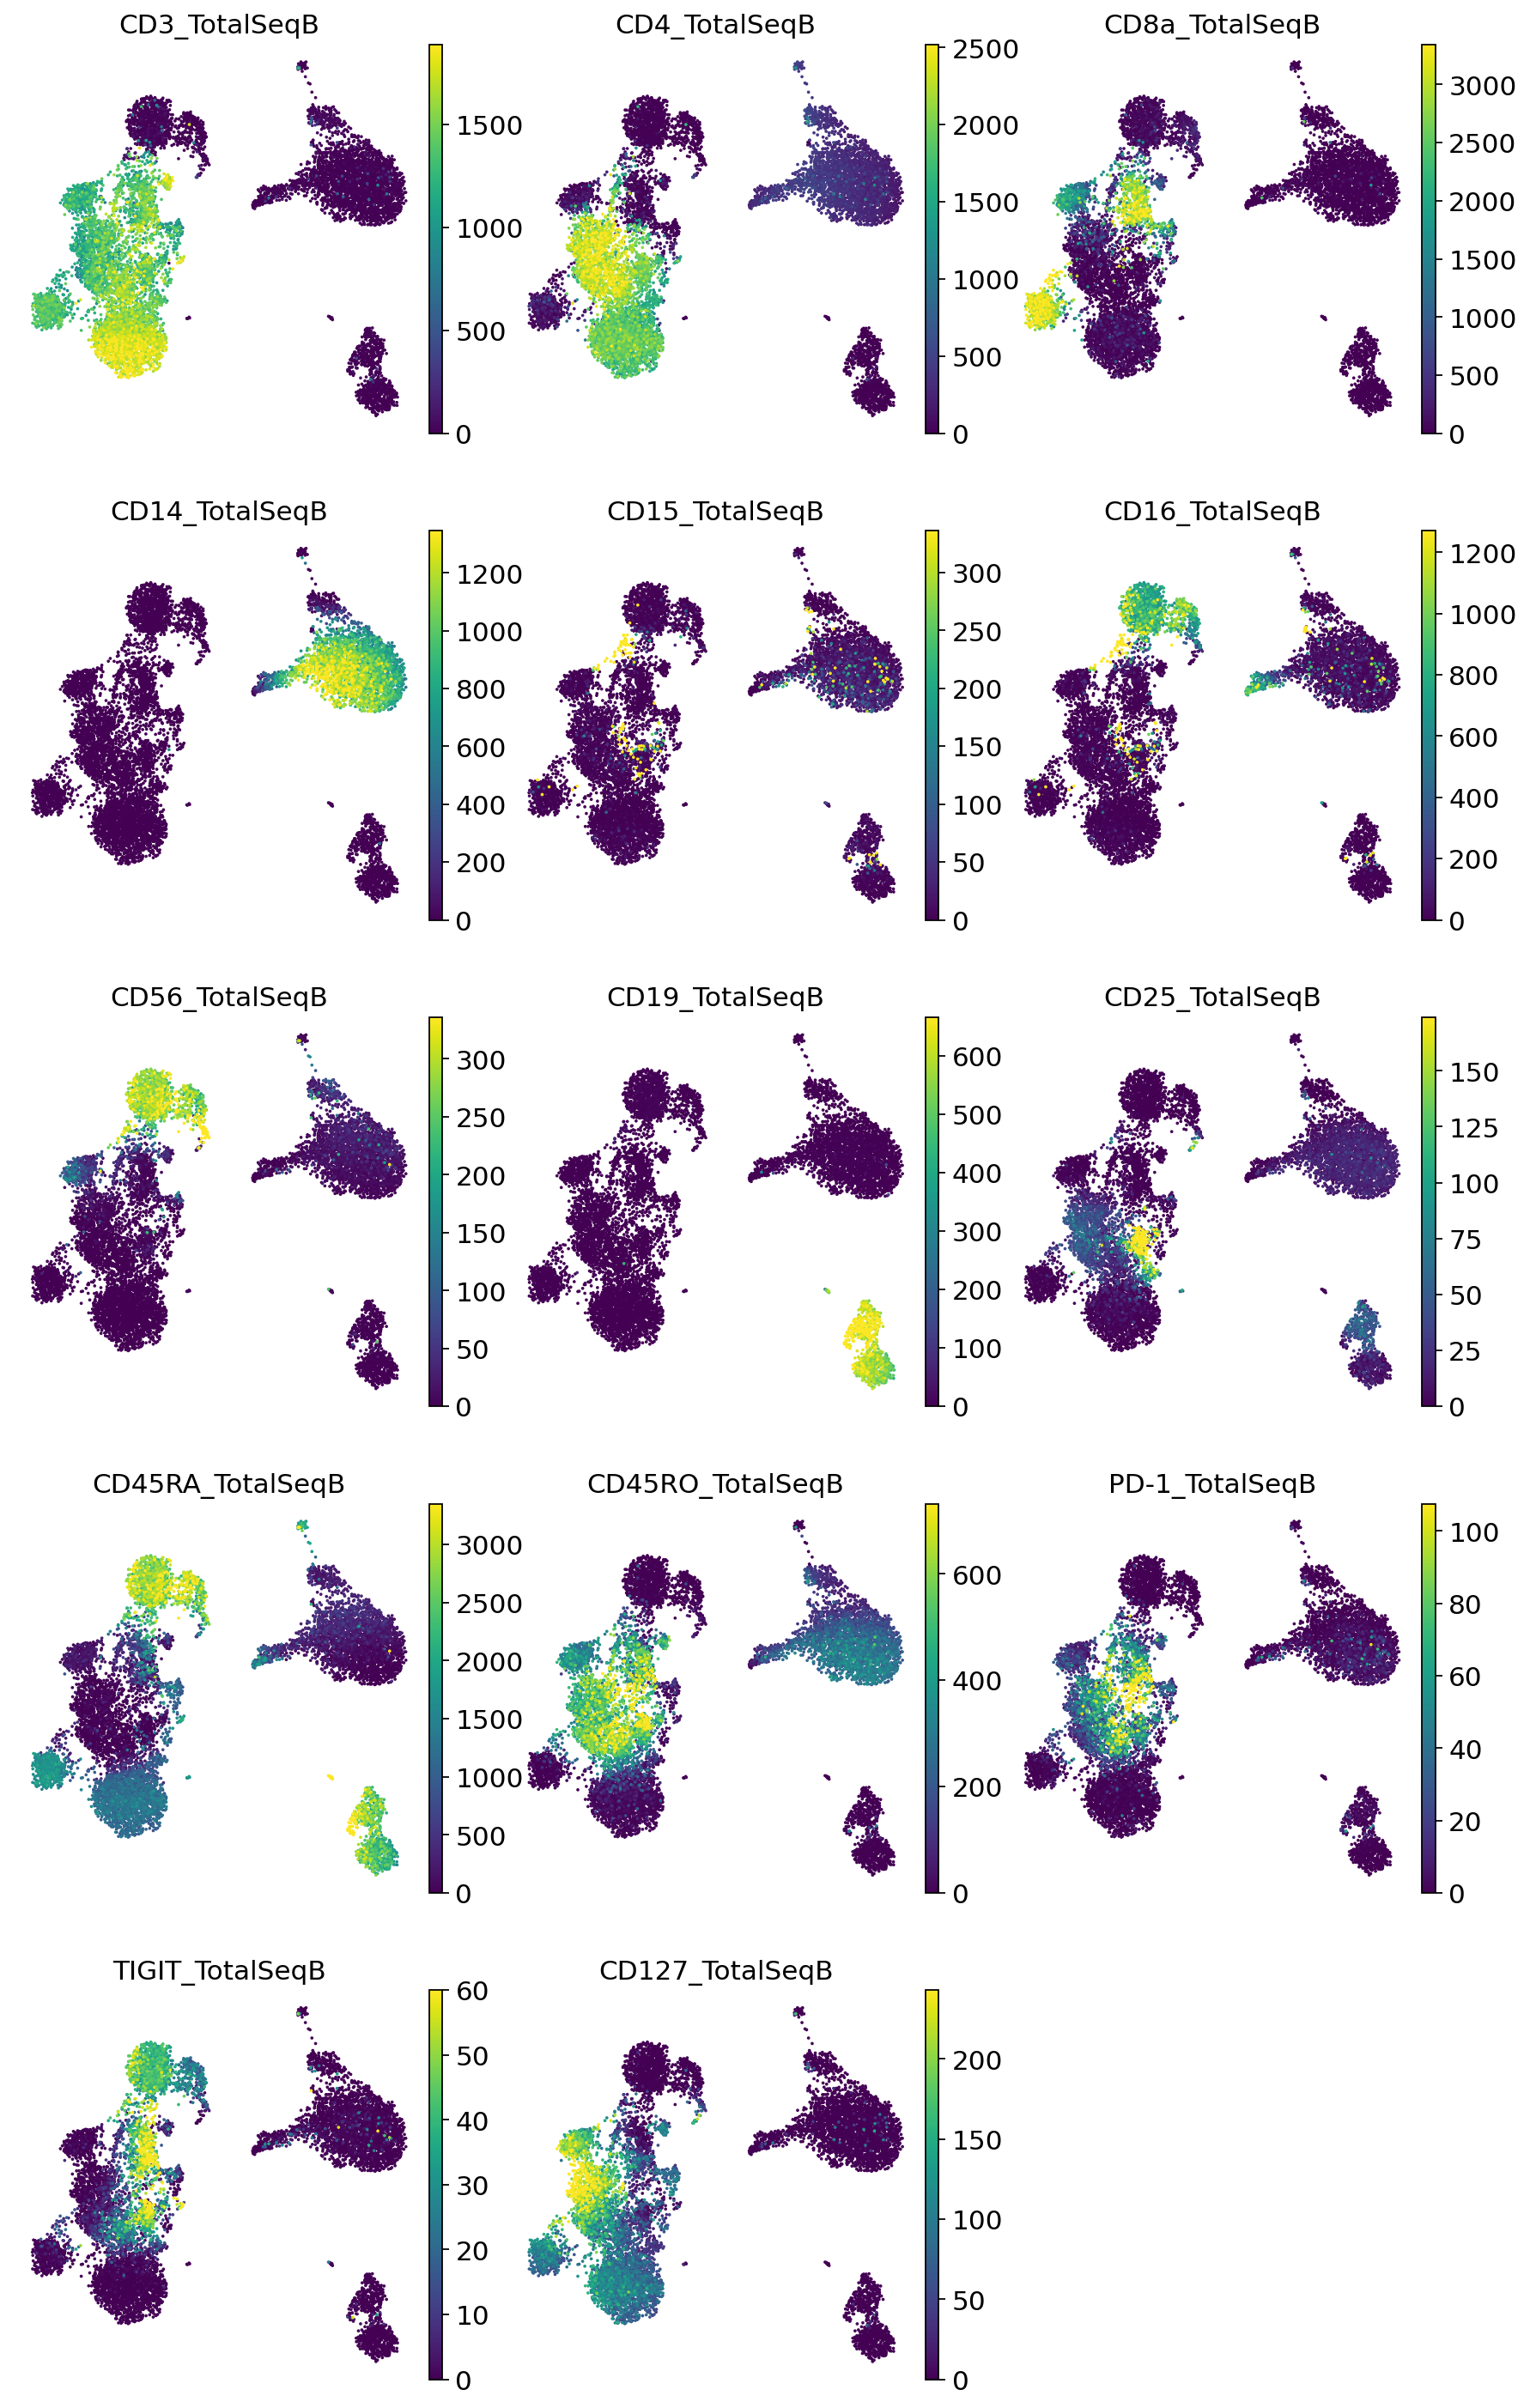

In [20]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="denoised_protein",
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

```{note}
While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.
```

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

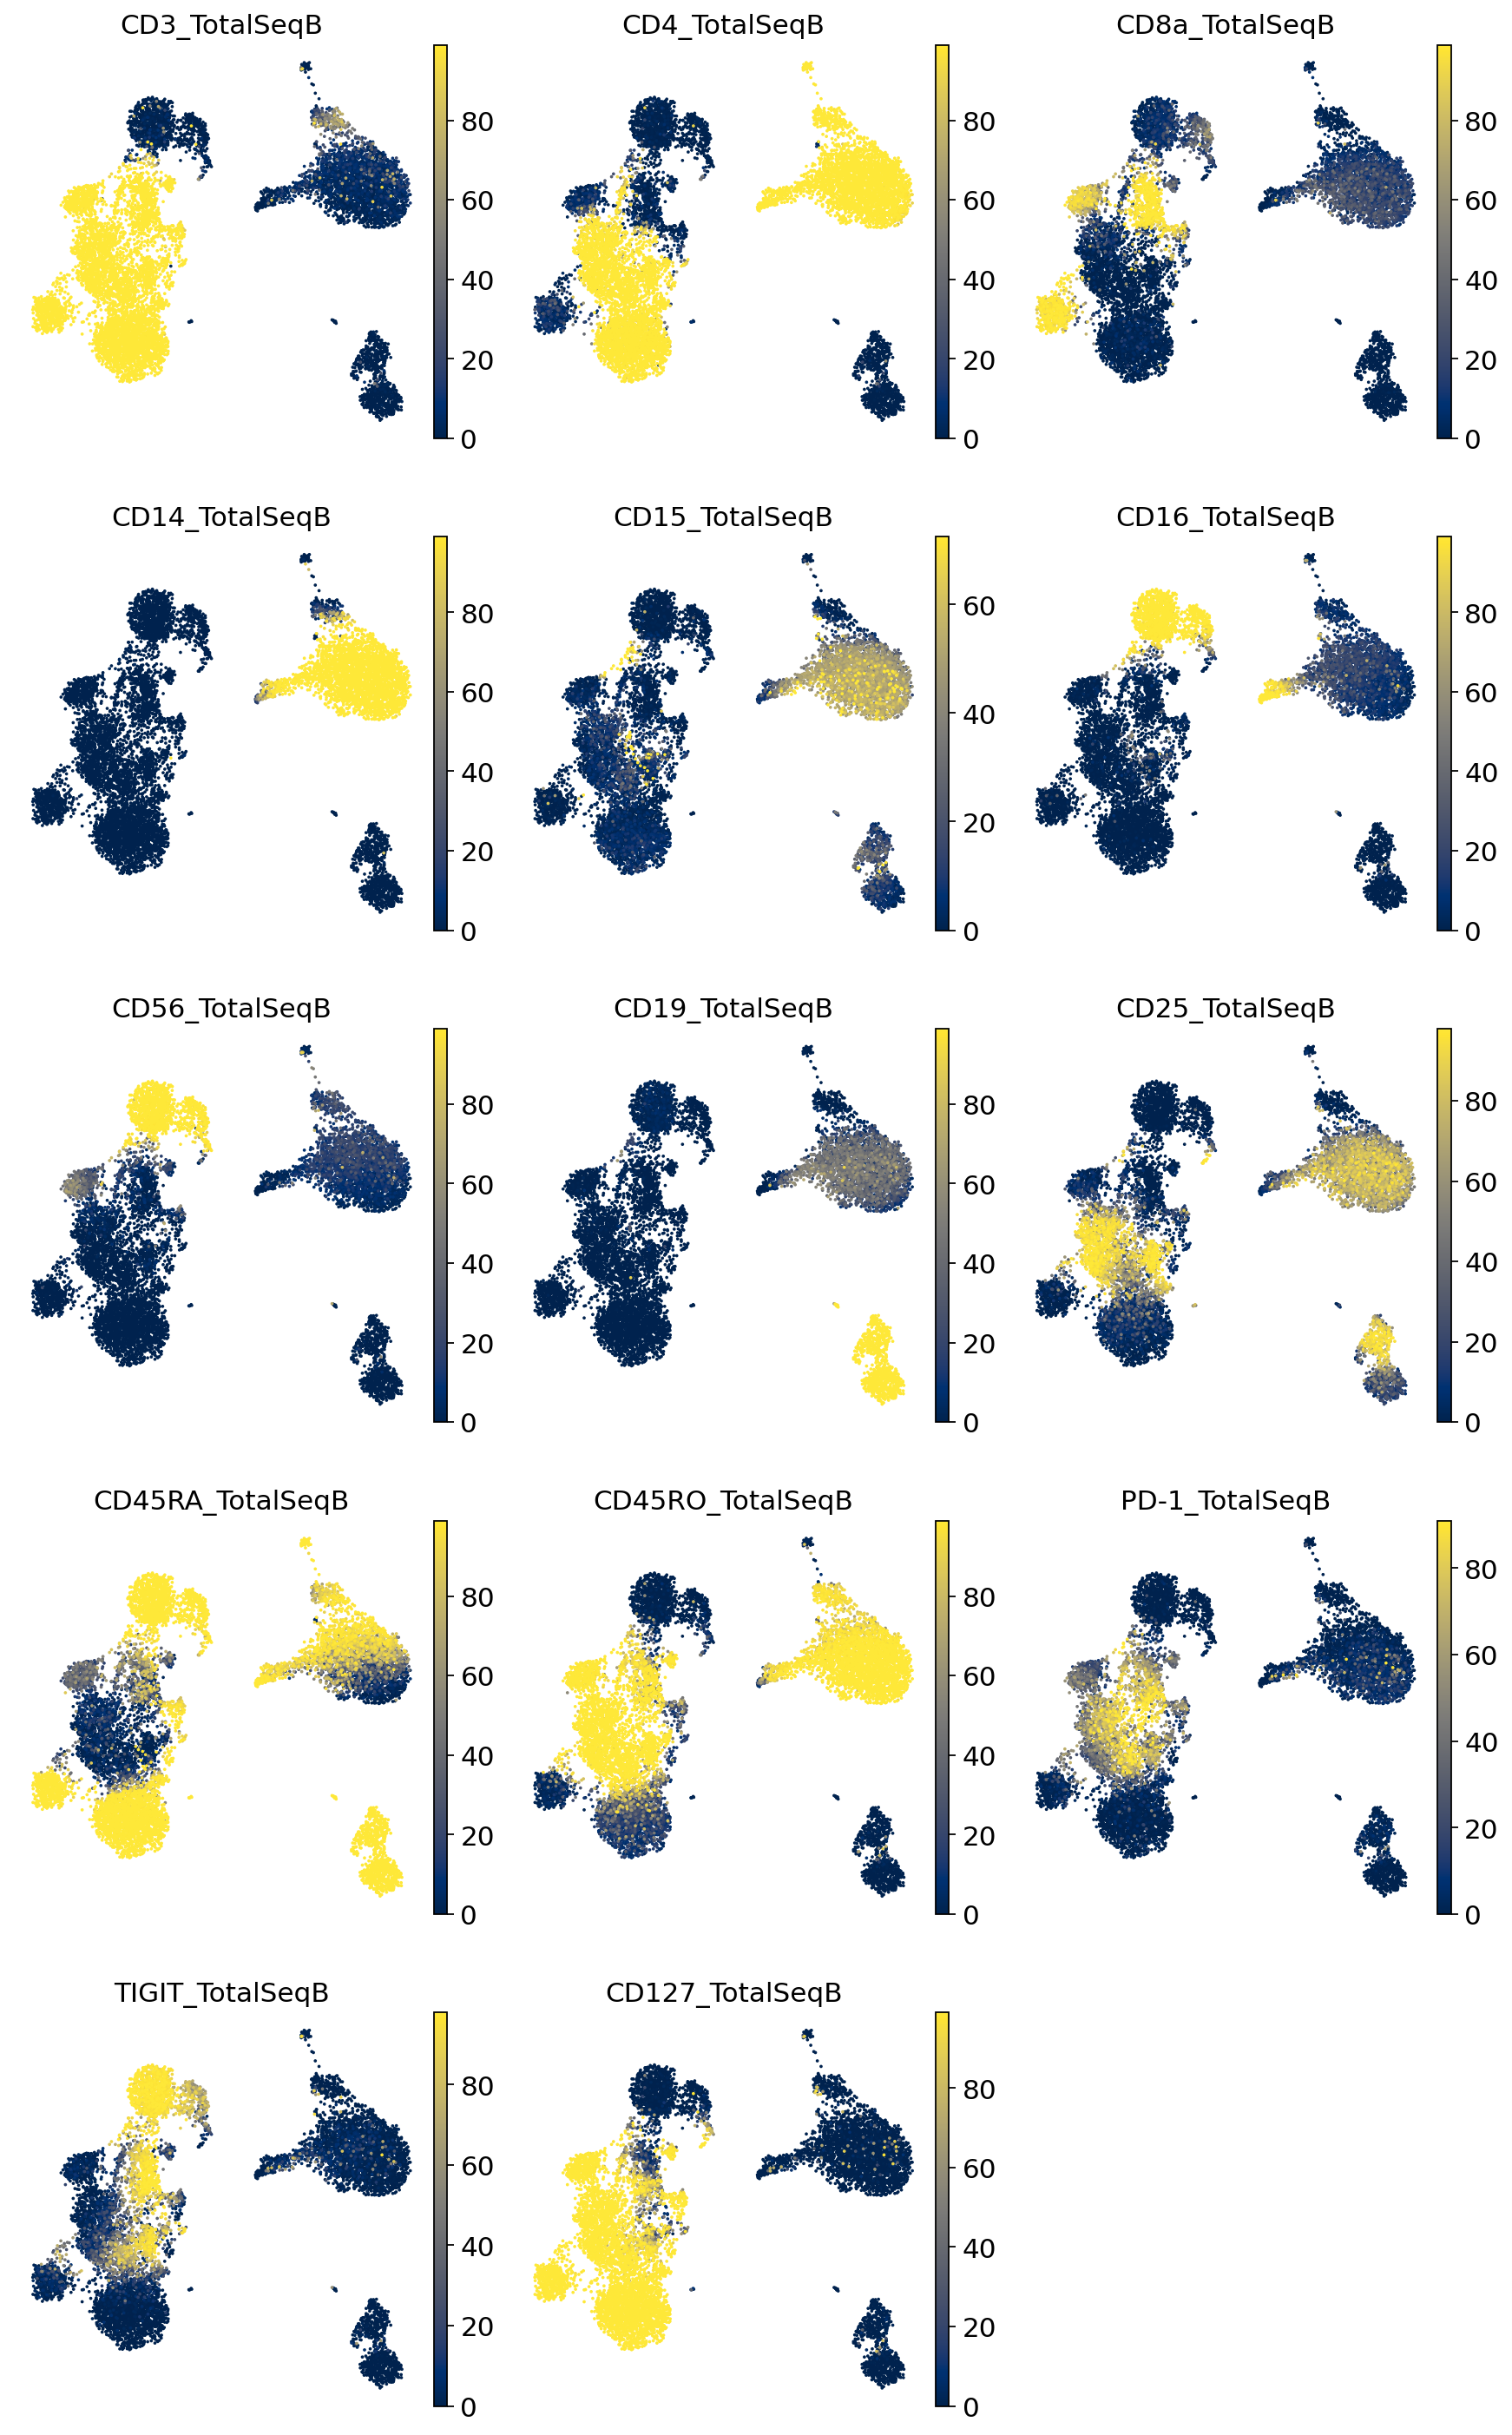

In [21]:
muon.pl.embedding(
    mdata,
    basis="rna_subset:X_umap",
    layer="protein_foreground_prob",
    color=protein.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    color_map="cividis",
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

```{important}
We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.
```

In [22]:
de_df = model.differential_expression(
    groupby="rna_subset:leiden_totalVI", delta=0.5, batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
ANKRD55    0.9862        0.0138      4.269190  0.000099  0.000006   
REG4       0.9812        0.0188      3.954919  0.000009  0.000004   
MYO1F      0.9776        0.0224      3.776039  0.000035  0.000744   
CA6        0.9760        0.0240      3.705408  0.000010  0.000002   
NOG        0.9756        0.0244      3.688469  0.000244  0.000016   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
ANKRD55           0.0    0.5  6.353032    6.681940  2.812860  ...   0.127775   
REG4              0.0    0.5  5.717388    6.070202  3.558983  ...   0.008121   
MYO1F             0.0    0.5 -4.554477   -4.926318  2.183192  ...   0.013535   
CA6               0.0    0.5  5.712849    5.919196  3.640814  ...   0.010287   
NOG               0.0    0.5  8.877319    9.526344  3.827953  ...   0.217109   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ANKRD55   0.009220               0.116405               0.008776   
REG4      0.004110               0.007580               0.003777   
MYO1F     1.470562               0.012453               0.589425   
CA6       0.002777               0.010287               0.002222   
NOG       0.016219               0.178127               0.014219   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
ANKRD55              1.641991              0.088449            True   
REG4                 0.086721              0.039889            True   
MYO1F                0.171044              7.967407            True   
CA6                  0.109388              0.027540            True   
NOG                  2.714708              0.207277            True   

         comparison  group1 group2  
ANKRD55   0 vs Rest       0   Rest  
REG4      0 vs Rest       0   Rest  
MYO1F     0 vs Rest       0   Rest  
CA6       0 vs Rest       0   Rest  
NOG       0 vs Rest       0   Rest  

[5 rows x 22 columns]

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [23]:
filtered_pro = {}
filtered_rna = {}
cats = rna.obs[TOTALVI_CLUSTERS_KEY].cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains("TotalSeqB")
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

We can also use general scanpy visualization functions

In [24]:
sc.tl.dendrogram(rna, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs[TOTALVI_CLUSTERS_KEY] = rna.obs[TOTALVI_CLUSTERS_KEY]
protein.obsm[TOTALVI_LATENT_KEY] = rna.obsm[TOTALVI_LATENT_KEY]
sc.tl.dendrogram(protein, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)

/env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


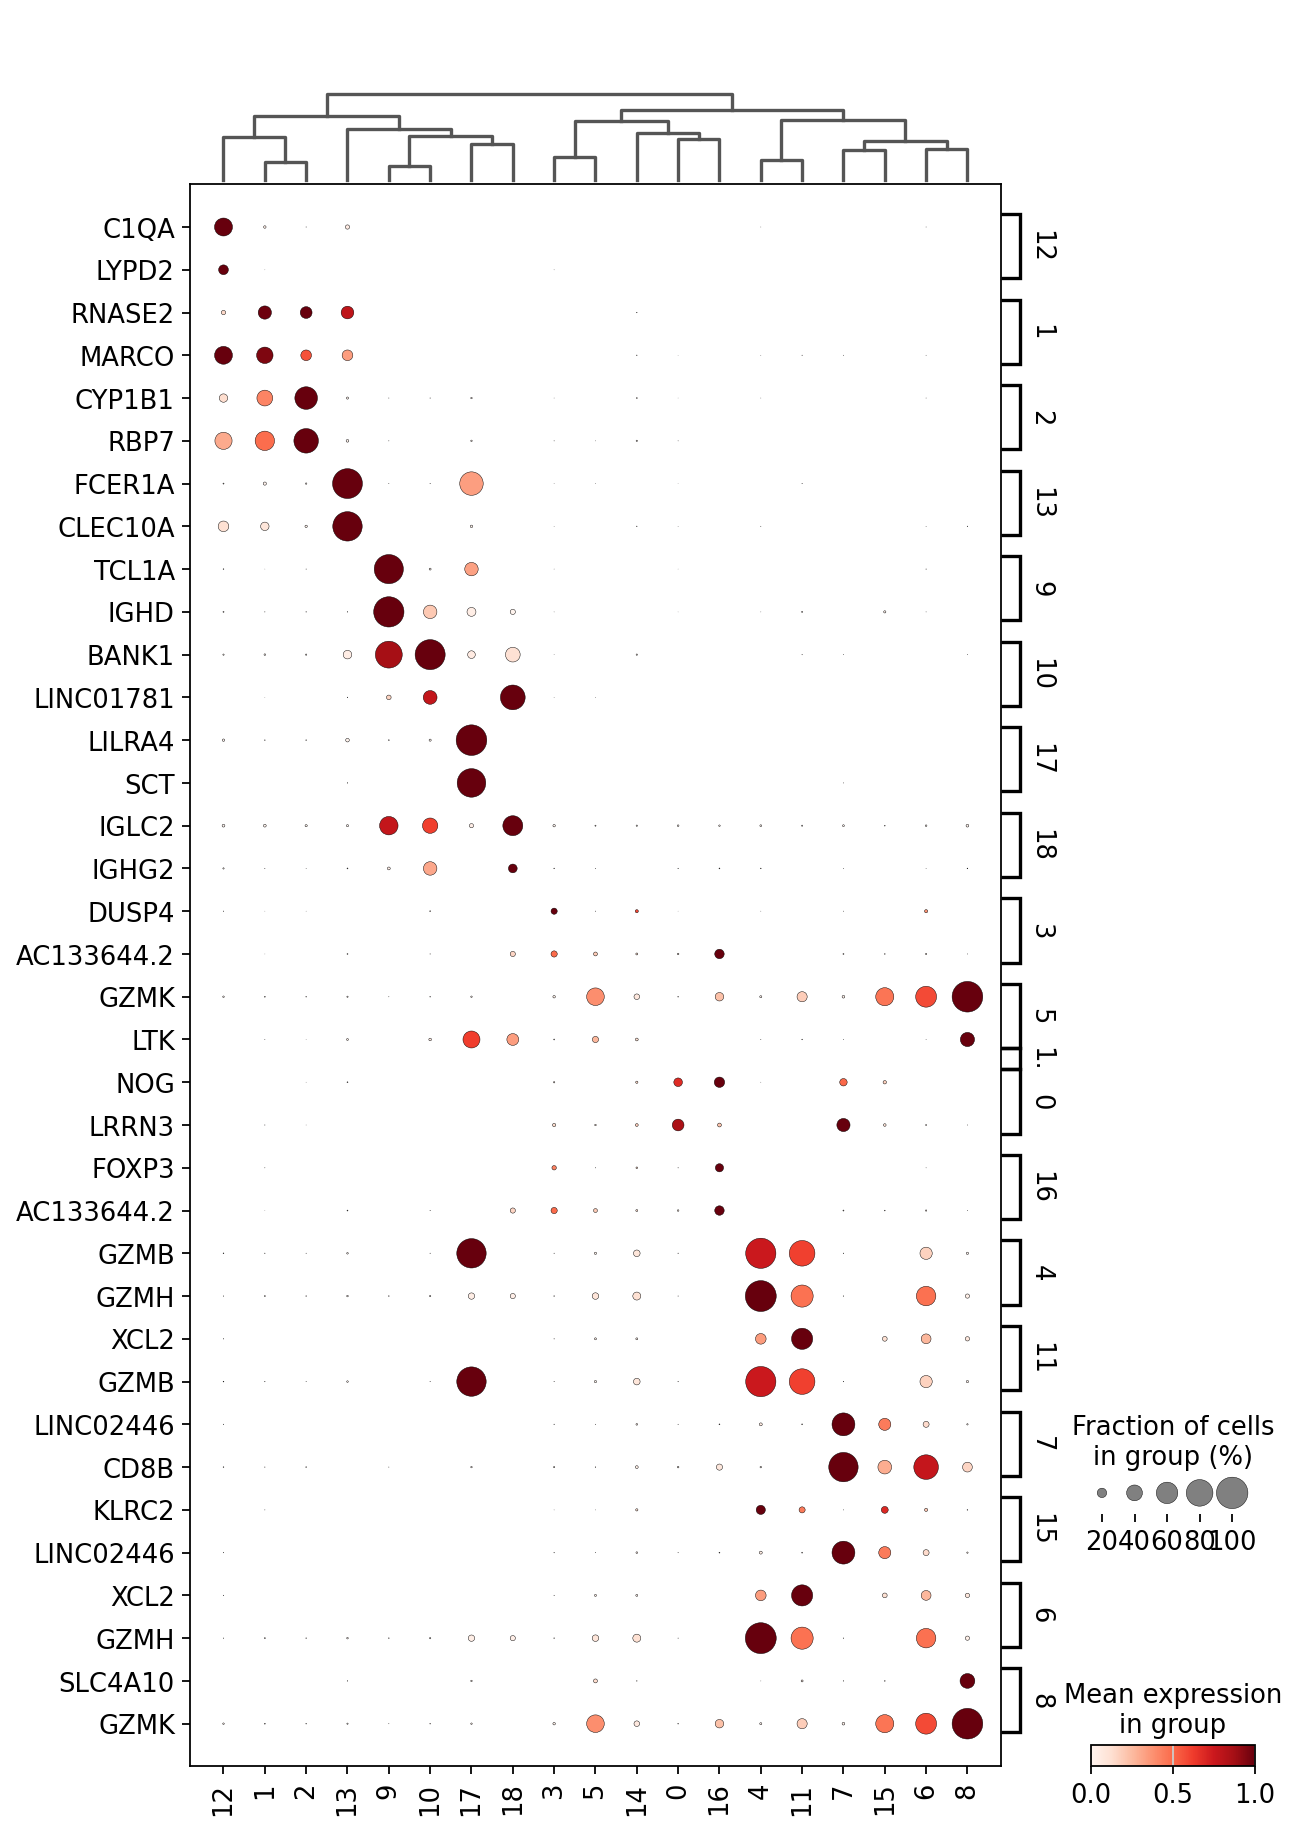

In [25]:
sc.pl.dotplot(
    rna,
    filtered_rna,
    groupby=TOTALVI_CLUSTERS_KEY,
    dendrogram=True,
    standard_scale="var",
    swap_axes=True,
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

/env/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/env/lib/python3.11/site-packages/scanpy/plotting/_baseplot_class.py:893: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_names_ordered = [self.var_names[x] for x in var_names_idx_ordered]


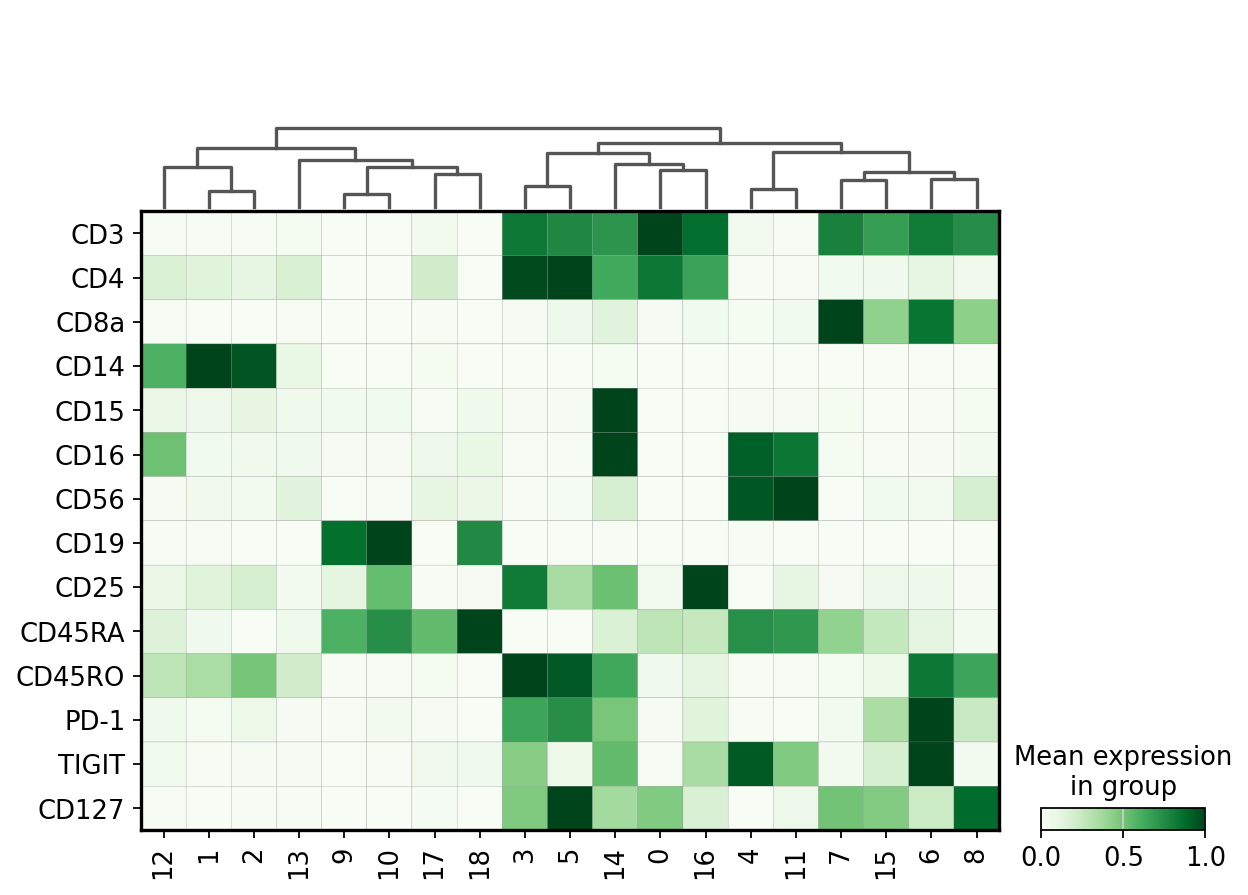

In [26]:
sc.pl.matrixplot(
    protein,
    protein.var["clean_names"],
    groupby=TOTALVI_CLUSTERS_KEY,
    gene_symbols="clean_names",
    dendrogram=True,
    swap_axes=True,
    layer="denoised_protein",
    cmap="Greens",
    standard_scale="var",
)

This is a selection of some of the markers that turned up in the RNA DE test.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


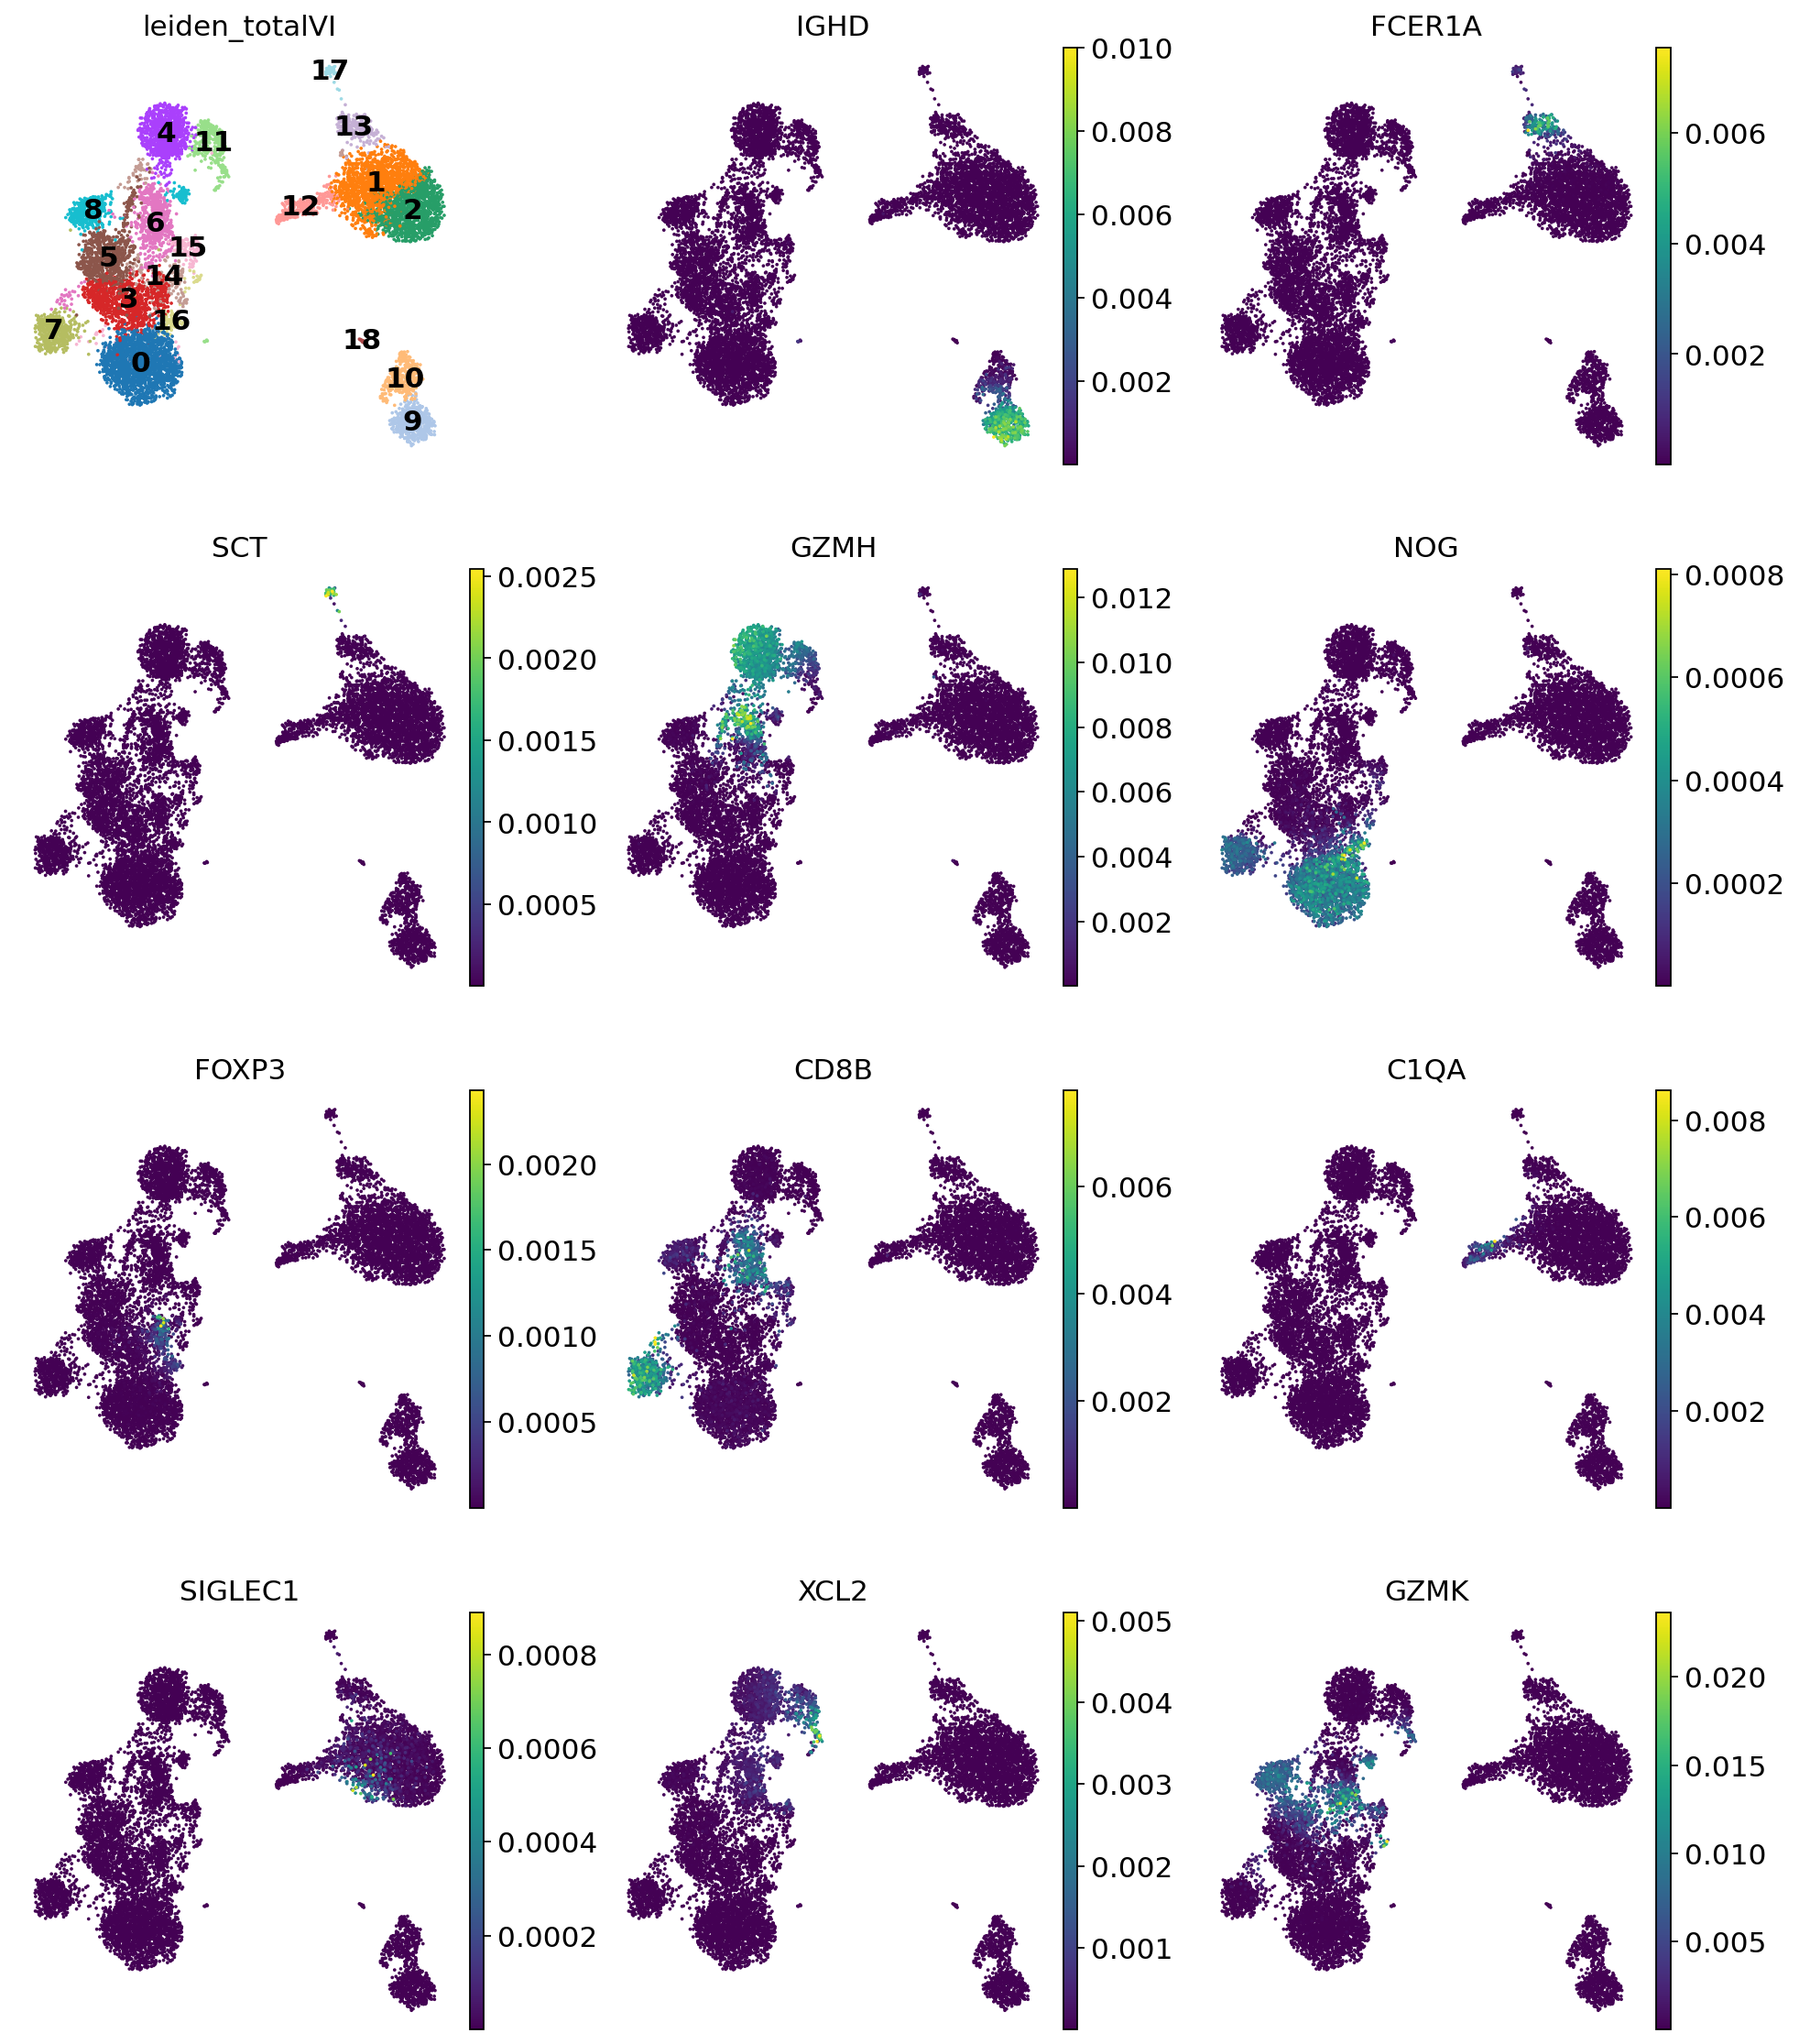

In [27]:
sc.pl.umap(
    rna,
    color=[
        TOTALVI_CLUSTERS_KEY,
        "IGHD",
        "FCER1A",
        "SCT",
        "GZMH",
        "NOG",
        "FOXP3",
        "CD8B",
        "C1QA",
        "SIGLEC1",
        "XCL2",
        "GZMK",
    ],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.2,
)